# I. MaxCut (4-regular ) QAOA at depth p=1 with 10 qubits (nodes)
1. Extending the TFQ whitepaper to a 4-regular MaxCut graph to at a depth of p=1 to compare the convergence in training for this model versus the example provided
    - Due to the higher degrees of freedom, this QAOA circuit will be larger so it is expected that the parameter convergence within a certain error $\epsilon$ will take longer

## Step 1
1. Create a 4-regular graph with 10 nodes to be mapped onto the qubit hardware

In [1]:
# Import necessary libraries
import tensorflow as tf
import tensorflow_quantum as tfq
import cirq
import sympy
import numpy as np

# visualization tools
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit
#supress warning for matplotlib
import warnings
warnings.filterwarnings("ignore")

# Used to make network
import networkx as nx
import random

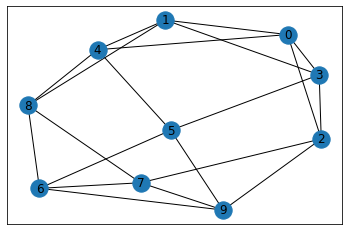

In [2]:
# Create a 4-regular graph with 10 nodes
random.seed()
maxcut_graph = nx.random_regular_graph(n=10, d=4)

# Visualize this graph 
nx.draw_networkx(maxcut_graph)


## Step 2
1. Create the QAOA circuit, first for only a p=1 depth 
2. Note that due to the 4-regular graph structure, the size of each QAOA block will be __increased by__ 5.
3. So given a depth-p QAOA circuit, the size of the circuit mapping a 4-regular, 10 node graph is increased by __5p__ relative to that of a circuit mapping a 3-regular, 10 node graph 

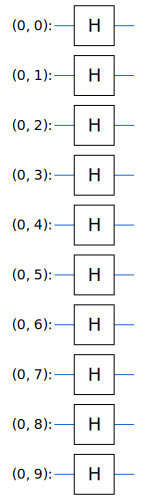

In [3]:
# Define the qubit structure
qubits = cirq.GridQubit.rect(1,10)

# Map qubits to 4-regular graph and apply the hadamard transform for 
#the initial superposition state for all qubits
hadamard_circuit = cirq.Circuit()
for node in maxcut_graph.nodes():
    qubit = qubits[node]
    hadamard_circuit.append(cirq.H(qubit))
    
SVGCircuit(hadamard_circuit)

1.000*X((0, 5))+1.000*X((0, 9))+1.000*X((0, 6))+1.000*X((0, 1))+1.000*X((0, 3))+1.000*X((0, 4))+1.000*X((0, 8))+1.000*X((0, 0))+1.000*X((0, 7))+1.000*X((0, 2))


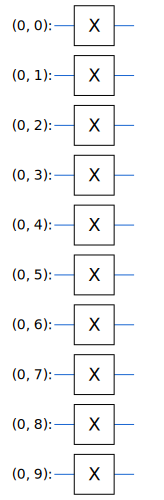

In [4]:
# Create the mixing hamiltonian
mixing_H = 0
for node in maxcut_graph.nodes():
    qubit = qubits[node]
    mixing_H += cirq.PauliString(cirq.X(qubit))
    
print(mixing_H)

m_H_circuit = cirq.Circuit(mixing_H)
#View the mixing Hamiltonian (should be X gate on all qubits)
SVGCircuit(m_H_circuit)

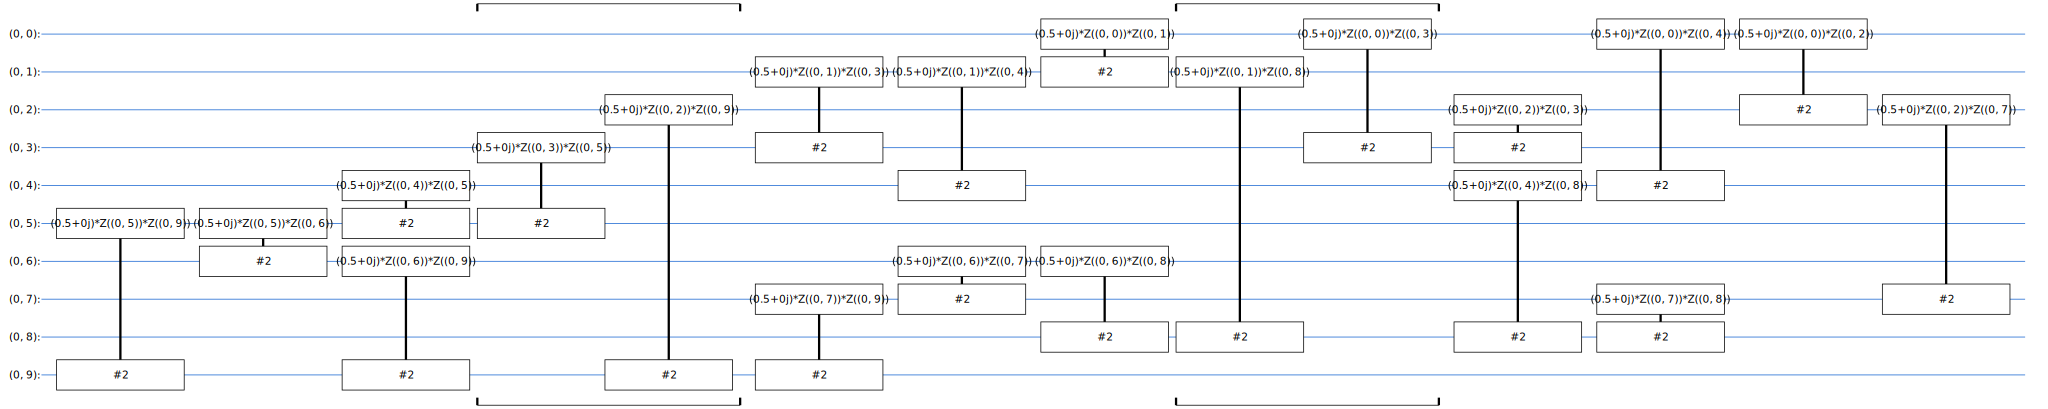

In [5]:
# Creat the cost Hamiltonian
cost_H = maxcut_graph.number_of_edges()/2

for edge in maxcut_graph.edges():
    # Map the edges to qubit architecture
    qubit1 = qubits[edge[0]]
    qubit2 = qubits[edge[1]]
    
    # Apply the ZZ gate on connected qubits
    cost_H += cirq.PauliString(1/2*cirq.Z(qubit1)*cirq.Z(qubit2))

# View cost Hamiltonian structure
c_H_circuit = cirq.Circuit(cost_H)
SVGCircuit(c_H_circuit)
    

    

In [6]:
# Compare structure to the 4-regular MaxCut graph edges to see if 
# they agree
for edge in maxcut_graph.edges():
    print(edge)

(5, 9)
(5, 6)
(5, 4)
(5, 3)
(9, 6)
(9, 2)
(9, 7)
(6, 7)
(6, 8)
(1, 3)
(1, 4)
(1, 0)
(1, 8)
(3, 0)
(3, 2)
(4, 8)
(4, 0)
(8, 7)
(0, 2)
(7, 2)


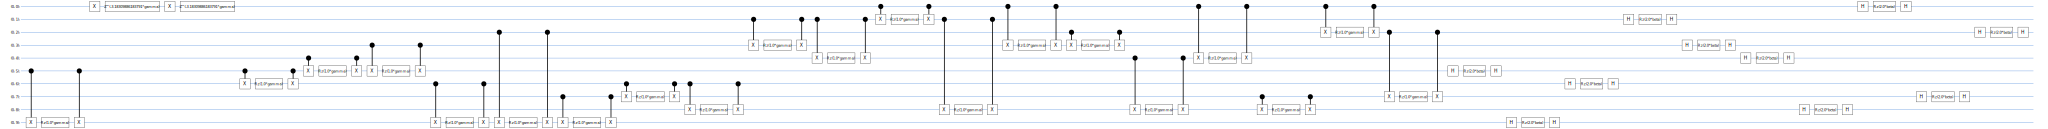

In [7]:
# Use SymPy to define the parameters for 1 block (p=1) of QAOA circuit
qaoa_params = sympy.symbols('gamma beta')

# Create the unitary ops that represent the QAOA circuit
qaoa_circuit = tfq.util.exponential(operators= 
                                    [cost_H, mixing_H],
                                   coefficients= qaoa_params)

# Visualize this circuit
SVGCircuit(qaoa_circuit)

## Step 3
1. Define the model, the model readout, and training data
2. Build the Keras model
3. Optimize the parameters for this particular ansatz state
    - Can be any optimizer, the Adam optimizer is chosen here 
    - I'm planning on playing around with different optimizers and determining which one is most efficient for this 4-regular, 10 node graph structure
4. Train the model

In [8]:

model_circuit = qaoa_circuit
model_readout = cost_H

# I belive this is the training data for our model
# as we have no input labels or data
input_val = [hadamard_circuit]
input_val_conv = tfq.convert_to_tensor(input_val)

# Provide the 'y' value for the model
optimum = [0]

In [9]:
# Build the Keras model
optimum = np.array(optimum)
optimum
complete_model = tf.keras.Sequential()

# Create an input layer
complete_model.add(tf.keras.layers.Input(shape=(), 
                                         dtype=tf.dtypes.string))

# Create a layer for the PQC
complete_model.add(tfq.layers.PQC(model_circuit, model_readout))

In [10]:
# Provide a specific loss fxn and optimizer method for complete_model
complete_model.compile(loss=tf.keras.losses.mean_absolute_error,
             optimizer=tf.keras.optimizers.Adam())

# Train the model and store the results
# Here the first argument is out 'feature column'
# Argument 2: Our minimization goal
results = complete_model.fit(input_val_conv, optimum, epochs=100,
                            verbose=1)

Train on 1 samples
Epoch 1/100
1/1 [==============================] - 1s 1s/sample - loss: 10.0397
Epoch 2/100
1/1 [==============================] - 0s 9ms/sample - loss: 10.0387
Epoch 3/100
1/1 [==============================] - 0s 8ms/sample - loss: 10.0378
Epoch 4/100
1/1 [==============================] - 0s 7ms/sample - loss: 10.0368
Epoch 5/100
1/1 [==============================] - 0s 7ms/sample - loss: 10.0359
Epoch 6/100
1/1 [==============================] - 0s 9ms/sample - loss: 10.0349
Epoch 7/100
1/1 [==============================] - 0s 7ms/sample - loss: 10.0340
Epoch 8/100
1/1 [==============================] - 0s 9ms/sample - loss: 10.0331
Epoch 9/100
1/1 [==============================] - 0s 7ms/sample - loss: 10.0323
Epoch 10/100
1/1 [==============================] - 0s 9ms/sample - loss: 10.0314
Epoch 11/100
1/1 [==============================] - 0s 9ms/sample - loss: 10.0306
Epoch 12/100
1/1 [==============================] - 0s 8ms/sample - loss: 10.0297
Epoch 1

In [32]:
# Extract the performance of the model
for epoch, loss in enumerate(results.history['loss']):
    print(f'Loss in epoch {epoch}: {loss}')

Loss in epoch 0: 10.039714813232422
Loss in epoch 1: 10.038732528686523
Loss in epoch 2: 10.037757873535156
Loss in epoch 3: 10.036800384521484
Loss in epoch 4: 10.035857200622559
Loss in epoch 5: 10.03493881225586
Loss in epoch 6: 10.034022331237793
Loss in epoch 7: 10.033138275146484
Loss in epoch 8: 10.032258987426758
Loss in epoch 9: 10.03140640258789
Loss in epoch 10: 10.03056526184082
Loss in epoch 11: 10.029742240905762
Loss in epoch 12: 10.028932571411133
Loss in epoch 13: 10.028133392333984
Loss in epoch 14: 10.027366638183594
Loss in epoch 15: 10.026605606079102
Loss in epoch 16: 10.025869369506836
Loss in epoch 17: 10.025146484375
Loss in epoch 18: 10.024436950683594
Loss in epoch 19: 10.023746490478516
Loss in epoch 20: 10.023061752319336
Loss in epoch 21: 10.022401809692383
Loss in epoch 22: 10.02175521850586
Loss in epoch 23: 10.021121978759766
Loss in epoch 24: 10.020511627197266
Loss in epoch 25: 10.019903182983398
Loss in epoch 26: 10.019319534301758
Loss in epoch 27: 

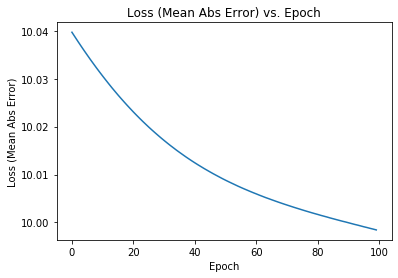

In [31]:
# Plot the performance
plt.plot(results.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss (Mean Abs Error)')
plt.title('Loss (Mean Abs Error) vs. Epoch')
plt.show()


# II. MaxCut QAOA (4-regular) at depth p=3 with 10 qubits (nodes)